In [3]:
import os
import pandas as pd
import shutil
from tqdm import tqdm

# Paths
metadata_path = "/Users/abi/Downloads/HAM10000_metadata.csv"
image_folder_1 = "/Users/abi/Downloads/HAM10000_images_part_1"
image_folder_2 = "/Users/abi/Downloads/HAM10000_images_part_2"
destination_folder = "/Users/abi/Desktop/MAJOR PROJECT/dataset/train"

# Read the metadata
metadata = pd.read_csv(metadata_path)

# Merge both image folders into a single source list
image_folders = [image_folder_1, image_folder_2]

# Ensure destination directory exists
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Create a folder for each unique category
categories = metadata["dx"].unique()
category_folders = {}
for category in categories:
    category_path = os.path.join(destination_folder, category)
    category_folders[category] = category_path
    if not os.path.exists(category_path):
        os.makedirs(category_path)

# Copy images into respective category folders
print("Organizing images...")
for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
    image_id = row["image_id"]
    category = row["dx"]

    # Locate the image file in the two source folders
    source_path = None
    for folder in image_folders:
        potential_path = os.path.join(folder, f"{image_id}.jpg")
        if os.path.exists(potential_path):
            source_path = potential_path
            break

    # If the image is found, copy it to the respective category folder
    if source_path:
        dest_path = os.path.join(category_folders[category], f"{image_id}.jpg")
        shutil.copy(source_path, dest_path)

print(f"Images organized successfully into '{destination_folder}'!")


Organizing images...


100%|███████████████████████████████████| 10015/10015 [00:08<00:00, 1233.25it/s]

Images organized successfully into '/Users/abi/Desktop/MAJOR PROJECT/dataset/train'!


Melonoma Prediction

In [3]:
#libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [5]:

data_dir_train = pathlib.Path("/Users/abi/Desktop/MAJOR PROJECT/dataset/train")


In [9]:
#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2806


Found 8134 files belonging to 5 classes.


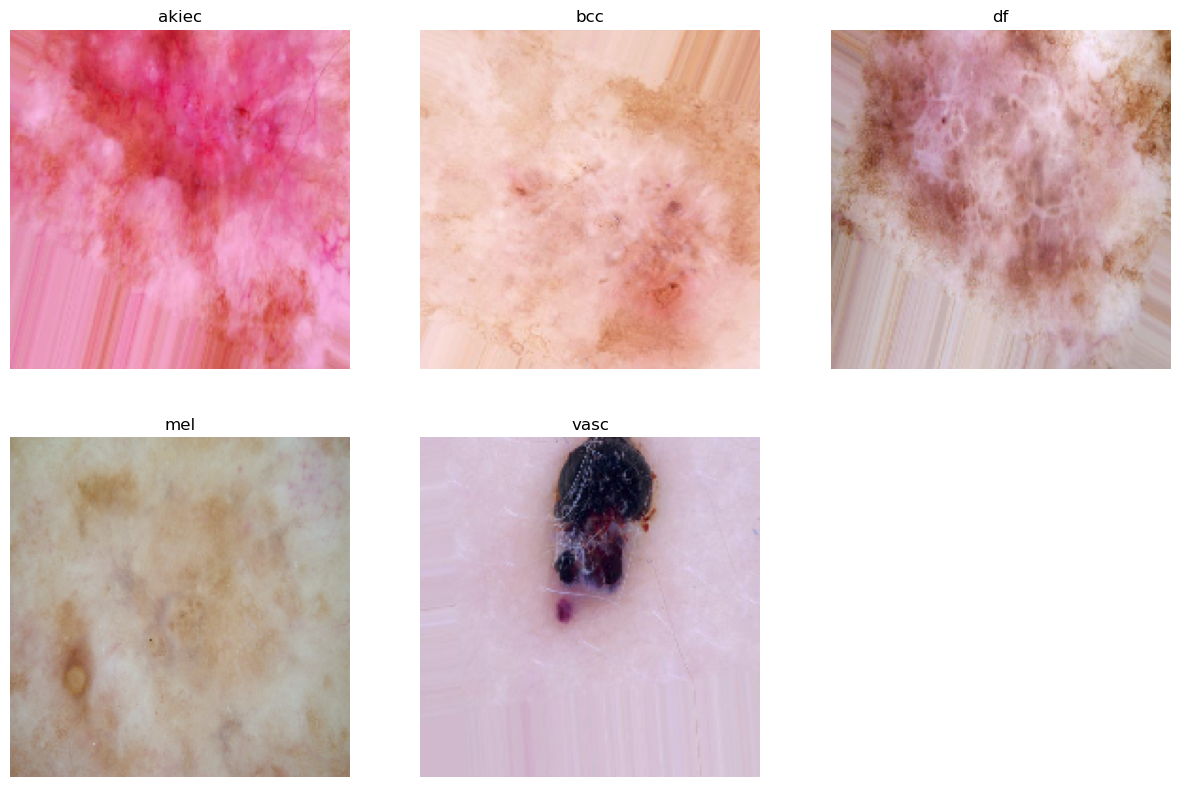

In [9]:

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [13]:
def class_distribution_count(directory):
    
   
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,akiec,328
1,df,116
2,vasc,143
3,bcc,515
4,mel,1708


<Axes: xlabel='No. of Image', ylabel='Class'>

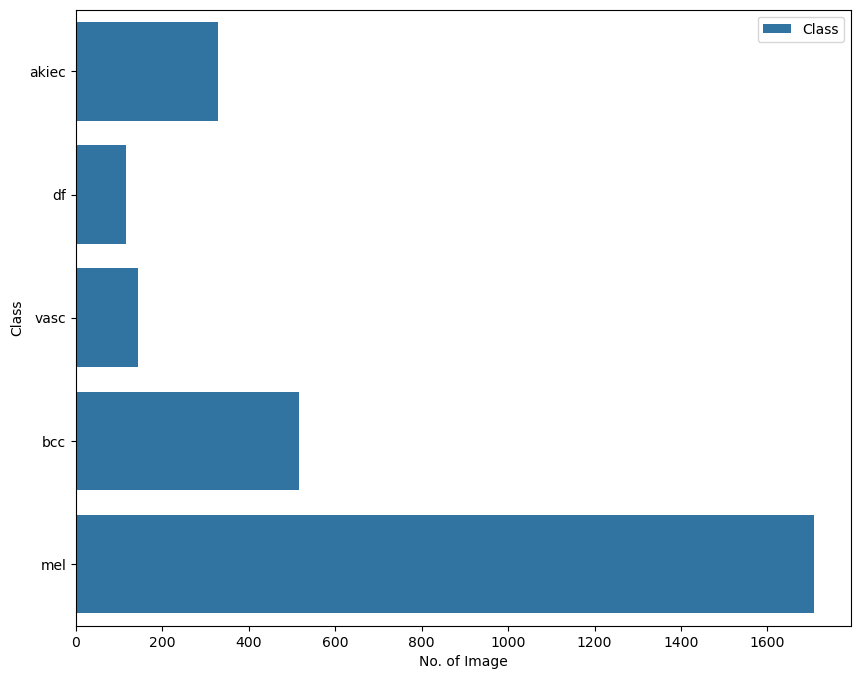

In [15]:

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [17]:
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img

# Paths
train_folder = "/Users/abi/Desktop/MAJOR PROJECT/dataset/train"
target_image_count = 1708  # Target number of images for all categories (same as 'mel')

# Augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=30,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom
    horizontal_flip=True,  # Horizontal flip
    fill_mode='nearest',  # Fill missing pixels after transformation
    brightness_range=[0.2, 1.5],  # Random brightness change
)

# Balance the dataset using augmentation
for category in os.listdir(train_folder):
    category_path = os.path.join(train_folder, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        current_count = len(images)

        print(f"Processing category '{category}': {current_count} images.")

        # Generate additional images if the count is less than the target
        if current_count < target_image_count:
            print(f"Augmenting {target_image_count - current_count} images for '{category}'...")
            while current_count < target_image_count:
                # Select a random image
                img_name = random.choice(images)
                img_path = os.path.join(category_path, img_name)

                # Load and preprocess the image
                img = load_img(img_path)
                img_array = img_to_array(img)
                img_array = img_array.reshape((1,) + img_array.shape)

                # Generate augmented images
                for batch in datagen.flow(img_array, batch_size=1, save_to_dir=category_path, save_prefix='aug', save_format='jpg'):
                    current_count += 1
                    if current_count >= target_image_count:
                        break

        # Print the final count after augmentation
        print(f"Category '{category}' now has {current_count} images.")

print("Dataset balanced successfully with augmentation!")


Processing category 'akiec': 328 images.
Augmenting 1380 images for 'akiec'...
Category 'akiec' now has 1708 images.
Processing category 'df': 116 images.
Augmenting 1592 images for 'df'...
Category 'df' now has 1708 images.
Processing category 'vasc': 143 images.
Augmenting 1565 images for 'vasc'...
Category 'vasc' now has 1708 images.
Processing category 'bcc': 515 images.
Augmenting 1193 images for 'bcc'...
Category 'bcc' now has 1708 images.
Processing category 'mel': 1708 images.
Category 'mel' now has 1708 images.
Dataset balanced successfully with augmentation!


In [19]:
# Train and validation dataset creation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=32, image_size=(180, 180), label_mode='categorical', seed=123, subset="training", validation_split=0.2
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=32, image_size=(180, 180), label_mode='categorical', seed=123, subset="validation", validation_split=0.2
)

# Caching and prefetching for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 8134 files belonging to 5 classes.
Using 6508 files for training.
Found 8134 files belonging to 5 classes.
Using 1626 files for validation.


In [21]:
# Model architecture
model = Sequential()

# Rescaling layer
model.add(layers.Rescaling(1. / 255, input_shape=(180, 180, 3)))

# Convolutional layers with Batch Normalization
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Dropout layer
model.add(layers.Dropout(0.5))

# Flatten and Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))

# Output layer
model.add(layers.Dense(len(class_names), activation='softmax'))

# Display the model summary
model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,517 (25.36 MB)

 Trainable params: 6,648,069 (25.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [23]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate for better convergence
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [27]:
from tensorflow.keras.callbacks import LearningRateScheduler  # Add this import at the top

# Callbacks for training
checkpoint = ModelCheckpoint(
    "good_model.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)
earlystop = EarlyStopping(
    monitor="val_accuracy", patience=5, mode="max", verbose=1
)

# Optional: Learning rate scheduler for dynamic learning rate adjustment
def lr_scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.1
    return lr

lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)



In [29]:
# Train the model
epochs = 30
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs, 
    callbacks=[checkpoint, earlystop, lr_callback]
)



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8034 - loss: 0.8898
Epoch 1: val_accuracy improved from -inf to 0.20049, saving model to good_model.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 95s 439ms/step - accuracy: 0.8036 - loss: 0.8883 - val_accuracy: 0.2005 - val_loss: 9.8526 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9019 - loss: 0.2892
Epoch 2: val_accuracy improved from 0.20049 to 0.47171, saving model to good_model.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 89s 435ms/step - accuracy: 0.9019 - loss: 0.2892 - val_accuracy: 0.4717 - val_loss: 2.3575 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9237 - loss: 0.2151
Epoch 3: val_accuracy improved from 0.47171 to 0.80627, saving model to good_model.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 89s 436ms/step - accuracy: 0.9237 - loss: 0.2151 - val_accuracy: 0.8063 - val_loss: 0.8323 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9418 - loss: 0.1722
Epoch 4: val_accuracy improved from 0.80627 to 0.90836, saving model to good_model.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 89s 438ms/step - accuracy: 0.9418 - loss: 0.1722 - val_accuracy: 0.9084 - val_loss: 0.2844 - learning_rate: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 5/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9559 - loss: 0.1382
Epoch 5: val_accuracy did not improve from 0.90836
204/204 ━━━━━━━━━━━━━━━━━━━━ 89s 436ms/step - accuracy: 0.9559 - loss: 0.1383 - val_accuracy: 0.9016 - val_loss: 0.3099 - learning_rate: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 6/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9564 - loss: 0.1169
Epoch 6: val_accuracy improved from 0.90836 to 0.92374, saving model to good_model.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 88s 433ms/step - accuracy: 0.9564 - loss: 0.1169 - val_accuracy: 0.9237 - val_loss: 0.2531 - learning_rate: 1.0000e-04

Epoch 7: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 7/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9708 - loss: 0.0877
Epoch 7: val_accuracy did not improve from 0.92374
204/204 ━━━━━━━━━━━━━━━━━━━━ 88s 433ms/step - accuracy: 0.9708 - loss: 0.0877 - val_accuracy: 0.9108 - val_loss: 0.2838 - learning_rate: 1.0000e-04

Epoch 8: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 8/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9764 - loss: 0.0691
Epoch 8: val_accuracy did not improve from 0.92374
204/204 ━━━━━━━━━━━━━━━━━━━━ 88s 431ms/step - accuracy: 0.9764 - loss: 0.0691 - val_accuracy: 0.9084 - val_loss: 0.3103 - learning_rate: 1.0000e-04

Epoch 9: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 9/30
204/204 ━━━━━━━━━━━━━━━━━━━

In [65]:
model.save('melanoma_detection_model_final.keras')  
print("Model saved successfully!")

Model saved successfully!


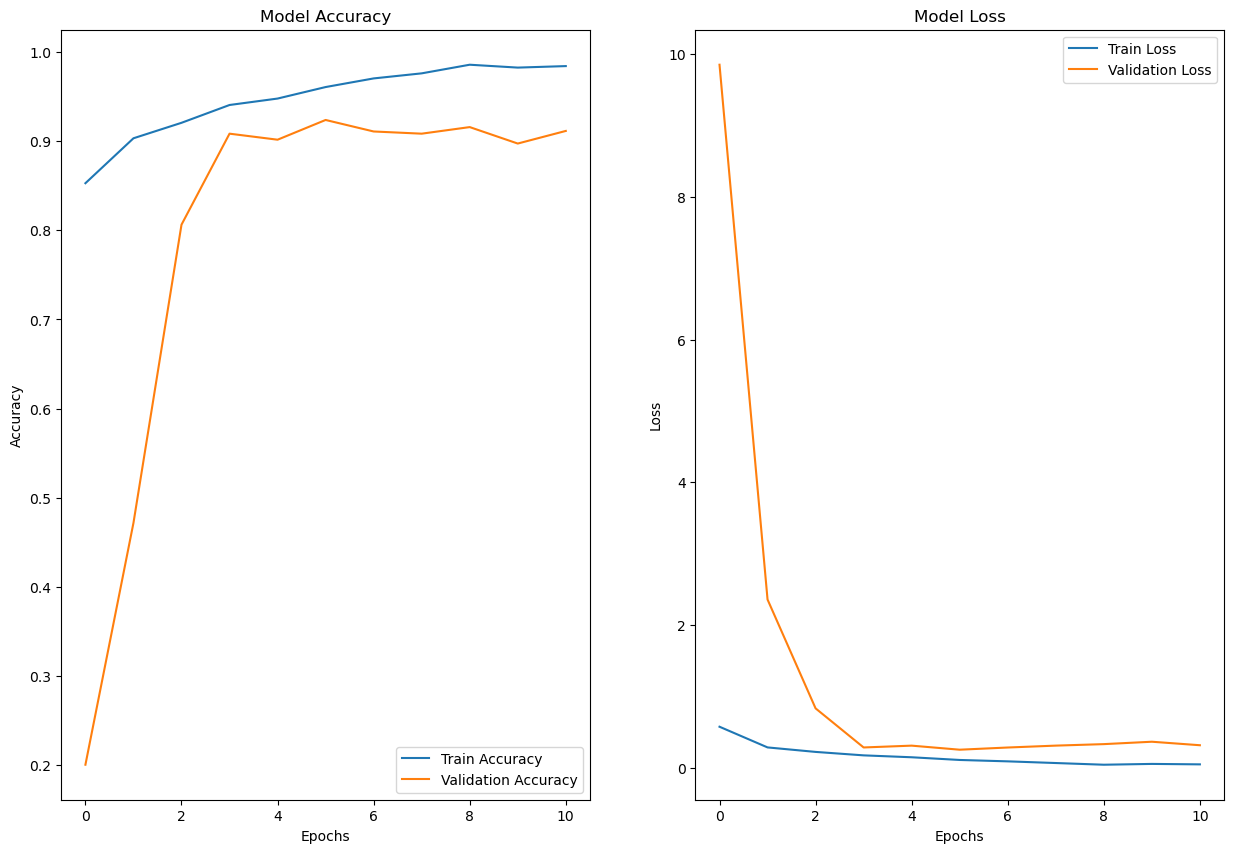

In [30]:
# Plot training and validation accuracy/loss
epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(15, 10))

# Plot model accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot model loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [103]:
# Get the training and validation accuracy from the last epoch
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

# Print the accuracy
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Training Accuracy: 98.42%
Validation Accuracy: 91.14%


In [7]:
data_dir_test = pathlib.Path("/Users/abi/Desktop/MAJOR PROJECT/dataset/test")

Found 67 files belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


2025-01-23 16:13:19.559118: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


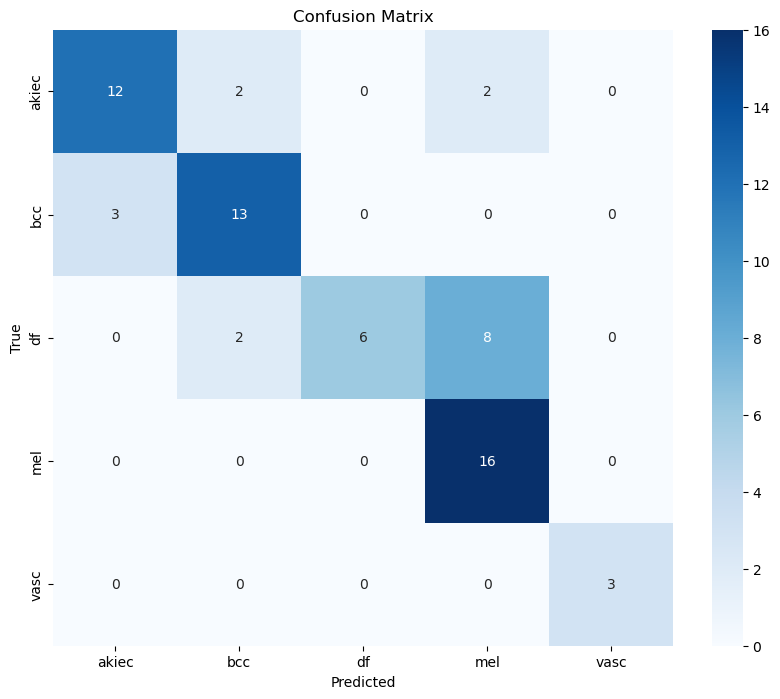

[[12  2  0  2  0]
 [ 3 13  0  0  0]
 [ 0  2  6  8  0]
 [ 0  0  0 16  0]
 [ 0  0  0  0  3]]


In [81]:
# Evaluate model on the test dataset
from sklearn.metrics import confusion_matrix  # Add this import at the top

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test, batch_size=32, image_size=(180, 180), label_mode='categorical'
)

# Get true labels and predictions
true_labels = []
pred_labels = []

for images, labels in test_ds:
    predictions = model.predict(images)
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    pred_labels.extend(np.argmax(predictions, axis=1))

# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
print(cm)


Model loaded successfully!


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Actual Class mel
Predictive Class mel


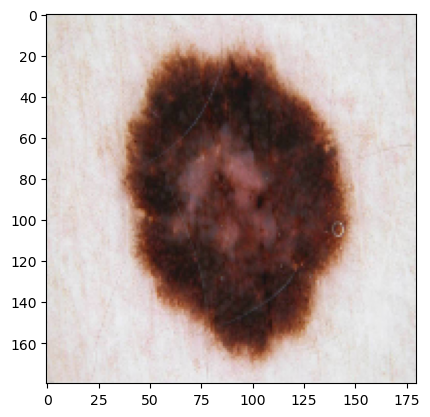

In [97]:
from glob import glob
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
model1 = load_model('melanoma_detection_model_final.keras')  # Replace with your model path
print("Model loaded successfully!")
Test_image_path = os.path.join(data_dir_test, class_names[3], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model1.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[3] +'\n'+ "Predictive Class "+pred_class )

Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Actual Class akiec
Predictive Class akiec


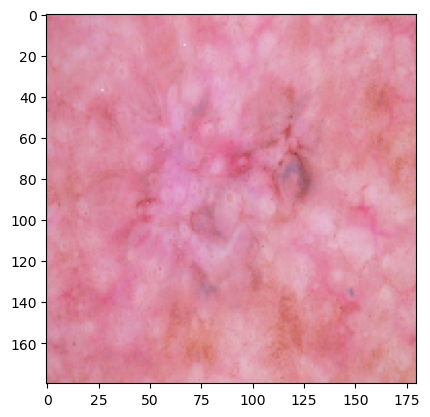

In [99]:
from glob import glob
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
model1 = load_model('melanoma_detection_model_final.keras')  # Replace with your model path
print("Model loaded successfully!")
Test_image_path = os.path.join(data_dir_test, class_names[0], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model1.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[0] +'\n'+ "Predictive Class "+pred_class )

Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Actual Class bcc
Predictive Class bcc


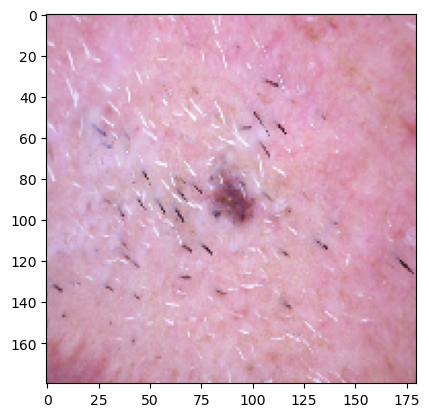

In [101]:
from glob import glob
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
model1 = load_model('melanoma_detection_model_final.keras')  # Replace with your model path
print("Model loaded successfully!")
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model1.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

Model loaded successfully!


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Actual Class df
Predictive Class df


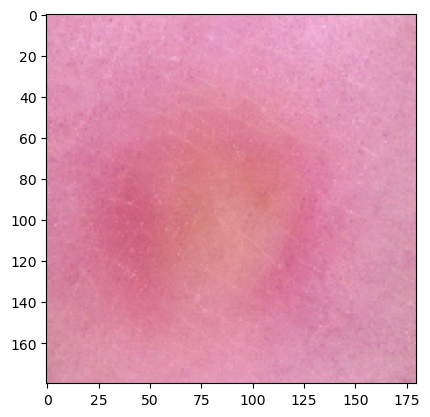

In [95]:
from glob import glob
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
model1 = load_model('melanoma_detection_model_final.keras')  # Replace with your model path
print("Model loaded successfully!")
Test_image_path = os.path.join(data_dir_test, class_names[2], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-2],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model1.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[2] +'\n'+ "Predictive Class "+pred_class )

Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Actual Class vasc
Predictive Class vasc


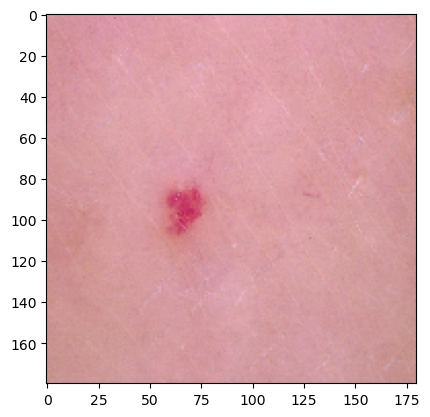

In [55]:
from glob import glob
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
model1 = load_model('melanoma_detection_model_final.keras')  # Replace with your model path
print("Model loaded successfully!")
Test_image_path = os.path.join(data_dir_test, class_names[4], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model1.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[4] +'\n'+ "Predictive Class "+pred_class )

Found 8134 files belonging to 5 classes.


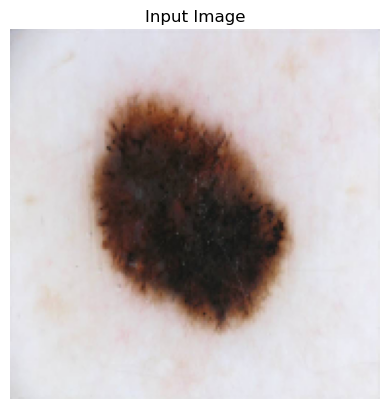

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00542101696919417..0.005678983245388736].


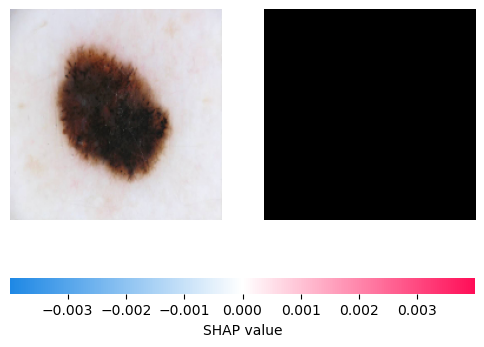

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
The model predicts the class as 'mel' with a probability of 1.00. Key regions contributing to the prediction are highlighted in the SHAP explanation above.


In [79]:
import pathlib
import tensorflow as tf
import shap
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load your trained model
model = tf.keras.models.load_model('melanoma_detection_model_final.keras')

# Define the path to your training dataset
data_dir_train = pathlib.Path("/Users/abi/Desktop/MAJOR PROJECT/dataset/train")

# Preprocess the dataset to create background data
batch_size = 32
img_height, img_width = 180, 180

# Create a dataset from the training directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Take a small batch as background data and convert to NumPy
background_data = next(iter(train_ds))  # Take the first batch of images
background_images = background_data[0].numpy()  # Extract images and convert to NumPy array

# Initialize SHAP's DeepExplainer
explainer = shap.DeepExplainer(model, background_images)

# Function to explain a prediction
def explain_prediction(image_path, class_names):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)

    # Get SHAP values
    shap_values = explainer.shap_values(img_array)

    # Display the original image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Visualize SHAP values (contributions of each pixel)
    shap.image_plot(shap_values, img_array)

    # Get predicted class and SHAP explanation
    pred = model.predict(img_array)
    pred_class = np.argmax(pred)
    prob_melanoma = pred[0][pred_class]

    # Generate textual explanation
    explanation = f"The model predicts the class as '{class_names[pred_class]}' with a probability of {prob_melanoma:.2f}. "
    explanation += "Key regions contributing to the prediction are highlighted in the SHAP explanation above."

    print(explanation)
    return explanation

# Test the function with a sample image

image_path = "/Users/abi/Desktop/MAJOR PROJECT/dataset/test/mel/ISIC_0000013.jpg"  # Replace with your test image
explanation = explain_prediction(image_path, class_names)



Found 8134 files belonging to 5 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(64, 180, 180, 3))']
  warnings.warn(msg)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 180, 180, 3))']
  warnings.warn(msg)


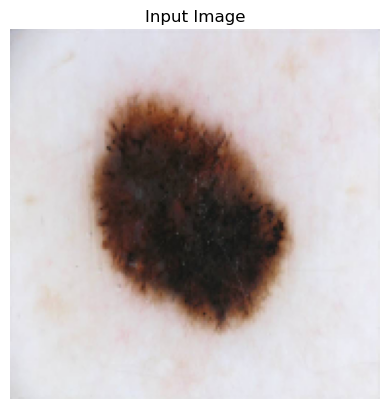

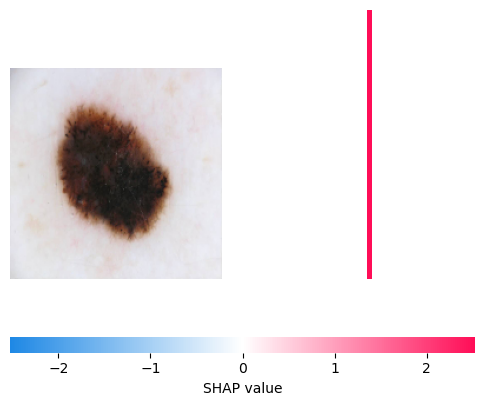

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
The model predicts the class as 'mel' with a probability of 1.00. Key regions contributing to the prediction are highlighted in the SHAP explanation above.


In [11]:
import pathlib
import tensorflow as tf
import shap
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load your trained model
model = tf.keras.models.load_model('melanoma_detection_model_final.keras')



# Preprocess the dataset to create background data
batch_size = 32
img_height, img_width = 180, 180

# Create a dataset from the training directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Take a small batch as background data and convert to NumPy
background_data = next(iter(train_ds))  # Take the first batch of images
background_images = background_data[0].numpy()  # Extract images and convert to NumPy array

# Initialize SHAP's DeepExplainer
explainer = shap.DeepExplainer(model, background_images)

# Function to explain a prediction
def explain_prediction(image_path, class_names):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)

    # Get SHAP values
    shap_values = explainer.shap_values(img_array)

    # Normalize SHAP values for visualization
    shap_min, shap_max = shap_values[0].min(), shap_values[0].max()
    normalized_shap_values = (shap_values[0] - shap_min) / (shap_max - shap_min)

    # Display the original image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Visualize SHAP values (contributions of each pixel)
    shap.image_plot([normalized_shap_values], img_array)

    # Get predicted class and SHAP explanation
    pred = model.predict(img_array)
    pred_class = np.argmax(pred)
    prob_melanoma = pred[0][pred_class]

    # Generate textual explanation
    explanation = f"The model predicts the class as '{class_names[pred_class]}' with a probability of {prob_melanoma:.2f}. "
    explanation += "Key regions contributing to the prediction are highlighted in the SHAP explanation above."

    print(explanation)
    return explanation


# Test the function with a sample image
image_path = "/Users/abi/Desktop/MAJOR PROJECT/dataset/test/mel/ISIC_0000013.jpg"  # Replace with your test image
explanation = explain_prediction(image_path, class_names)


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Found 67 files belonging to 5 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Class names: ['akiec', 'bcc', 'df', 'mel', 'vasc']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


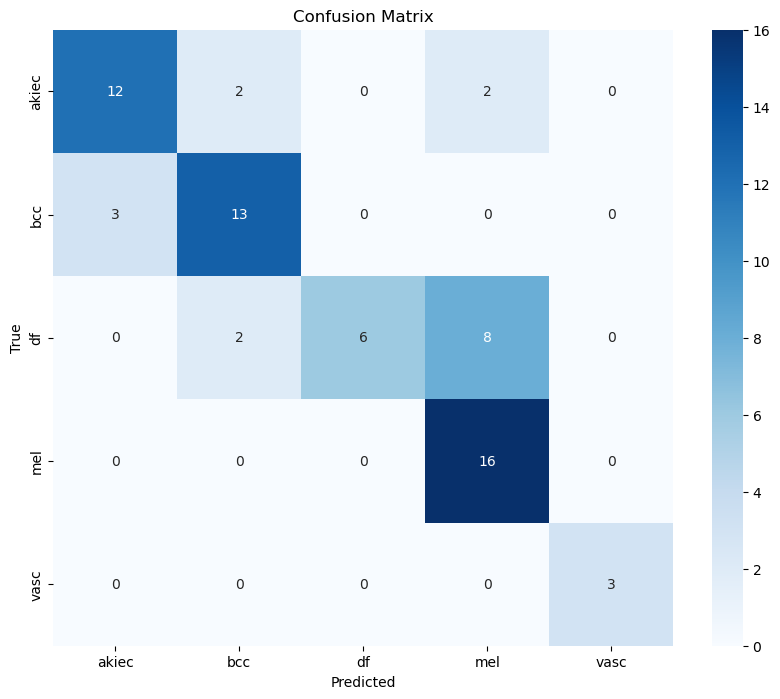

[[12  2  0  2  0]
 [ 3 13  0  0  0]
 [ 0  2  6  8  0]
 [ 0  0  0 16  0]
 [ 0  0  0  0  3]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Class: mel


AttributeError: The layer sequential has never been called and thus has no defined input.

In [37]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns  # Add this import
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from glob import glob  # Add this import

# Load the model
model1 = tf.keras.models.load_model('melanoma_detection_model_final.keras')  # Replace with your model path
print("Model loaded successfully!")

# Run a dummy forward pass to initialize the model's graph
dummy_input = np.zeros((1, 180, 180, 3))  # Adjust shape to match your input shape (180, 180, 3)
model1.predict(dummy_input)

# Load the test dataset
data_dir_test = '/Users/abi/Desktop/MAJOR PROJECT/dataset/test'  # Path to the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test, batch_size=32, image_size=(180, 180), label_mode='categorical'
)

# Get class names (optional, based on how your dataset is structured)
class_names = test_ds.class_names
print("Class names:", class_names)

# Function to compute Grad-CAM
def compute_gradcam(model, img_array, layer_name="conv2d_2"):
    # Get the last convolutional layer
    last_conv_layer = model.get_layer(layer_name)
    
    # Create a model that maps the input image to the activations of the last conv layer and the predictions
    grad_model = tf.keras.models.Model(
        [model.input], [last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        # Record the forward pass of the image
        conv_output, predictions = grad_model(img_array)
        # The target class is the predicted class
        target_class = np.argmax(predictions[0])

        # Get the gradients of the predicted class with respect to the last conv layer
        grads = tape.gradient(predictions[:, target_class], conv_output)
    
    # Pool the gradients across all the channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()

    # Get the feature map of the last conv layer
    conv_output = conv_output[0].numpy()

    # Weight the feature maps by the pooled gradients
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    # Compute the heatmap by averaging the feature maps along the depth axis
    heatmap = np.mean(conv_output, axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    return heatmap

# Function to overlay the heatmap on the image
def overlay_heatmap(heatmap, img_path, alpha=0.4):
    # Load the image
    img = load_img(img_path)
    img = img_to_array(img)
    
    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert the heatmap to RGB format
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay the heatmap on the original image
    superimposed_img = heatmap * alpha + img

    # Plot the result
    plt.figure(figsize=(10, 8))
    plt.imshow(superimposed_img / 255.)
    plt.axis('off')
    plt.show()

# Function to evaluate the model on the test dataset and visualize Grad-CAM
def evaluate_model_and_gradcam(model, test_ds, class_names):
    true_labels = []
    pred_labels = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        true_labels.extend(np.argmax(labels.numpy(), axis=1))
        pred_labels.extend(np.argmax(predictions, axis=1))

    # Create confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    print(cm)

    # Visualize Grad-CAM for a random image in the test set
    test_image_path = os.path.join(data_dir_test, class_names[3], '*')  # Select an image from class[3]
    test_image = glob(test_image_path)
    test_image = load_img(test_image[-1], target_size=(180, 180))  # Take a random image from the class
    img_array = img_to_array(test_image)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict class
    pred = model.predict(img_array)
    pred_class = np.argmax(pred)
    print(f"Predicted Class: {class_names[pred_class]}")

    # Compute Grad-CAM heatmap
    heatmap = compute_gradcam(model, img_array)

    # Overlay Grad-CAM on the test image
    overlay_heatmap(heatmap, test_image_path)

# Call the evaluation and Grad-CAM function
evaluate_model_and_gradcam(model1, test_ds, class_names)


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Found 67 files belonging to 5 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Class names: ['akiec', 'bcc', 'df', 'mel', 'vasc']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


2025-01-24 11:01:44.763602: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


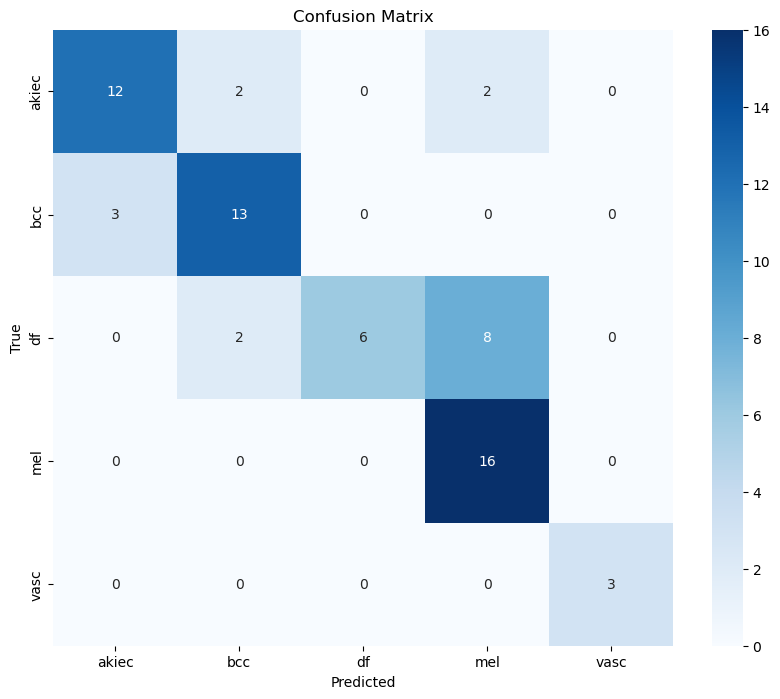

[[12  2  0  2  0]
 [ 3 13  0  0  0]
 [ 0  2  6  8  0]
 [ 0  0  0 16  0]
 [ 0  0  0  0  3]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Class: mel


AttributeError: The layer sequential has never been called and thus has no defined input.

In [41]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from glob import glob

# Load the model
model1 = tf.keras.models.load_model('melanoma_detection_model_final.keras')  # Replace with your model path
print("Model loaded successfully!")

# Ensure the model is called to initialize it
dummy_input = np.zeros((1, 180, 180, 3))  # Adjust shape to match your input shape (180, 180, 3)
model1.predict(dummy_input)  # Make a dummy pass through the model to initialize

# Load the test dataset
data_dir_test = '/Users/abi/Desktop/MAJOR PROJECT/dataset/test'  # Path to the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test, batch_size=32, image_size=(180, 180), label_mode='categorical'
)

# Get class names (optional, based on how your dataset is structured)
class_names = test_ds.class_names
print("Class names:", class_names)

# Function to compute Grad-CAM
def compute_gradcam(model, img_array, layer_name="conv2d_2"):
    # Get the last convolutional layer using model.layers
    last_conv_layer = model.get_layer(layer_name)
    
    # Create a model that maps the input image to the activations of the last conv layer and the predictions
    grad_model = tf.keras.models.Model(
        [model.input], [last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        # Record the forward pass of the image
        conv_output, predictions = grad_model(img_array)
        # The target class is the predicted class
        target_class = np.argmax(predictions[0])

        # Get the gradients of the predicted class with respect to the last conv layer
        grads = tape.gradient(predictions[:, target_class], conv_output)
    
    # Pool the gradients across all the channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()

    # Get the feature map of the last conv layer
    conv_output = conv_output[0].numpy()

    # Weight the feature maps by the pooled gradients
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    # Compute the heatmap by averaging the feature maps along the depth axis
    heatmap = np.mean(conv_output, axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    return heatmap

# Function to overlay the heatmap on the image
def overlay_heatmap(heatmap, img_path, alpha=0.4):
    # Load the image
    img = load_img(img_path)
    img = img_to_array(img)
    
    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert the heatmap to RGB format
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay the heatmap on the original image
    superimposed_img = heatmap * alpha + img

    # Plot the result
    plt.figure(figsize=(10, 8))
    plt.imshow(superimposed_img / 255.)
    plt.axis('off')
    plt.show()

# Function to evaluate the model on the test dataset and visualize Grad-CAM
def evaluate_model_and_gradcam(model, test_ds, class_names):
    true_labels = []
    pred_labels = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        true_labels.extend(np.argmax(labels.numpy(), axis=1))
        pred_labels.extend(np.argmax(predictions, axis=1))

    # Create confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    print(cm)

    # Visualize Grad-CAM for a random image in the test set
    test_image_path = os.path.join(data_dir_test, class_names[3], '*')  # Select an image from class[3]
    test_image = glob(test_image_path)
    test_image = load_img(test_image[-1], target_size=(180, 180))  # Take a random image from the class
    img_array = img_to_array(test_image)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict class
    pred = model.predict(img_array)
    pred_class = np.argmax(pred)
    print(f"Predicted Class: {class_names[pred_class]}")

    # Compute Grad-CAM heatmap
    heatmap = compute_gradcam(model, img_array)

    # Overlay Grad-CAM on the test image
    overlay_heatmap(heatmap, test_image_path)

# Call the evaluation and Grad-CAM function
evaluate_model_and_gradcam(model1, test_ds, class_names)


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Actual Class: mel
Predicted Class: mel


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


AttributeError: The layer sequential has never been called and thus has no defined output.

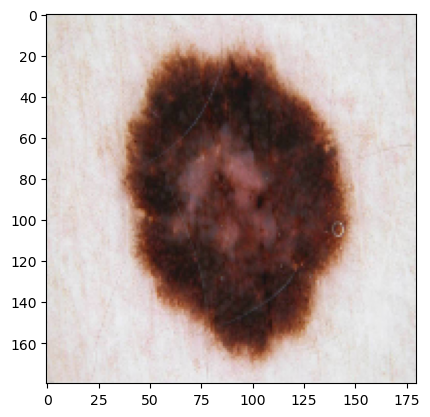

In [47]:
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Load the trained model
model1 = load_model('melanoma_detection_model_final.keras')
print("Model loaded successfully!")

# Test image path
Test_image_path = os.path.join(data_dir_test, class_names[3], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1], target_size=(180, 180))

# Display the test image
plt.imshow(Test_image)
plt.grid(False)

# Preprocess the image for prediction
img = np.expand_dims(img_to_array(Test_image), axis=0)  # Add batch dimension
img = img / 255.0  # Rescale the image as done during training

# Predict the class
pred = model1.predict(img)
pred_class_idx = np.argmax(pred)
pred_class = class_names[pred_class_idx]

# Print the actual class and predicted class
print("Actual Class: " + class_names[3])
print("Predicted Class: " + pred_class)

# Grad-CAM function
def compute_gradcam(model, img_array, layer_name="conv2d_2"):
    last_conv_layer = model.get_layer(layer_name)
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Pool gradients across all axes
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.squeeze(heatmap)  # Remove extra dimensions
    
    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)  # ReLU to focus on positive gradients
    heatmap /= np.max(heatmap)  # Normalize to [0, 1]
    
    return heatmap

# Function to overlay Grad-CAM
def overlay_gradcam(heatmap, img_array, alpha=0.4):
    img = np.array(img_array[0])
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)  # Convert heatmap to an 8-bit image
    heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)  # Apply heatmap colormap
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_resized, alpha, 0)  # Superimpose the heatmap
    return superimposed_img

# Compute Grad-CAM for the image
heatmap = compute_gradcam(model1, img)

# Overlay Grad-CAM on the image
gradcam_img = overlay_gradcam(heatmap, img)

# Show the Grad-CAM result
plt.figure(figsize=(10, 10))
plt.imshow(gradcam_img)
plt.axis('off')
plt.title(f"Grad-CAM for class: {pred_class}")
plt.show()


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted Class: mel


ValueError: No such layer: dense_2. Existing layers are: ['rescaling', 'conv2d', 'batch_normalization', 'max_pooling2d', 'conv2d_1', 'batch_normalization_1', 'max_pooling2d_1', 'conv2d_2', 'batch_normalization_2', 'max_pooling2d_2', 'dropout', 'flatten', 'dense', 'dropout_1', 'dense_1'].

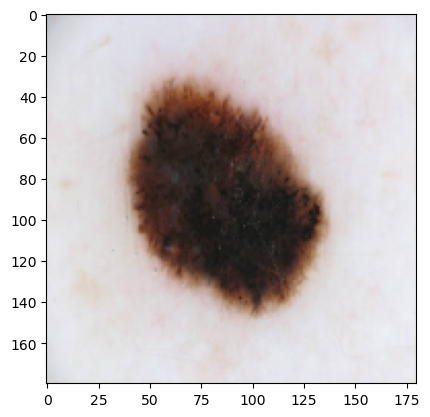

In [67]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the trained model
model1 = load_model('melanoma_detection_model_final.keras')  # Replace with your model path
print("Model loaded successfully!")

# Load the test image
test_image_path = "/Users/abi/Desktop/MAJOR PROJECT/dataset/test/mel/ISIC_0000013.jpg"  # Replace with your test image path
Test_image = load_img(test_image_path, target_size=(180, 180))
plt.imshow(Test_image)
plt.grid(False)

# Preprocess the image
img = np.expand_dims(Test_image, axis=0)  # Add batch dimension
# Preprocess the image (no need for img_to_array here, since it's already done)
img_array = img[0] / 255.0  # Rescale the image

# Make prediction
pred = model1.predict(np.expand_dims(img_array, axis=0)) 
pred_class = np.argmax(pred)
 # Replace with your actual class names
print(f"Predicted Class: {class_names[pred_class]}")

# Function to compute Grad-CAM
def compute_gradcam(model, img_array, last_conv_layer_name, last_dense_layer_name):
    # Get the last convolutional layer and last dense layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_dense_layer = model.get_layer(last_dense_layer_name)

    # Create a new model that outputs the last convolutional layer and the final predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [last_conv_layer.output, last_dense_layer.output]
    )

    # Record operations with GradientTape
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)  # Get conv outputs and predictions
        class_channel = predictions[:, pred_class]  # Get the output channel for the predicted class

    # Compute gradients
    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling of gradients

    # Multiply the pooled gradients with the convolutional output
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)  # ReLU to remove negative values
    heatmap /= np.max(heatmap)  # Normalize the heatmap to [0, 1]

    return heatmap

# Function to overlay heatmap on image
def overlay_heatmap(heatmap, img):
    img = img[0]  # Remove batch dimension
    img = np.array(img * 255, dtype=np.uint8)

    # Resize the heatmap to match the image size
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)
    heatmap = np.repeat(heatmap, 3, axis=-1)  # Convert heatmap to 3 channels for color

    # Apply colormap
    heatmap = plt.get_cmap("jet")(heatmap)[:, :, :3]  # Use jet colormap and remove alpha channel

    # Superimpose the heatmap onto the image
    superimposed_img = heatmap * 0.4 + img  # 0.4 for the transparency of the heatmap
    superimposed_img = np.uint8(superimposed_img)

    return superimposed_img

# Compute Grad-CAM for the image
last_conv_layer_name = 'conv2d_2'  # Replace with your last conv layer name
last_dense_layer_name = 'dense_2'  # Replace with your last dense layer name
heatmap = compute_gradcam(model1, img_array, last_conv_layer_name, last_dense_layer_name)

# Overlay Grad-CAM on the image
gradcam_img = overlay_heatmap(heatmap, img)

# Plot the image with Grad-CAM
plt.imshow(gradcam_img)
plt.axis('off')
plt.show()



In [75]:
# Load the model
from tensorflow.keras.models import load_model
model1 = load_model('melanoma_detection_model_final.keras')  # Replace with your model path
print("Model loaded successfully!")

# Define the last convolutional layer
last_conv_layer_name = "dense_1"  # Based on your model summary

# Grad-CAM Computation Function
def compute_gradcam(model, img_array, layer_name):
    # Define the model that outputs the last conv layer's output and the final prediction
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        # Record the operations that compute the gradients
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]  # Get the gradient for the class predicted

    # Compute the gradient of the loss with respect to the convolutional outputs
    grads = tape.gradient(loss, conv_outputs)

    # Global average pooling to get a 1D vector of feature map importance
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the pooled gradients with the convolutional output
    conv_outputs = conv_outputs[0]
    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # Compute the heatmap by averaging over all channels
    heatmap = np.mean(conv_outputs, axis=-1)

    # Normalize the heatmap to [0, 1]
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Preprocess the image
img = np.expand_dims(Test_image, axis=0)  # Add batch dimension
img_array = img / 255.0  # Rescale the image

# Compute Grad-CAM
heatmap = compute_gradcam(model1, img_array, last_conv_layer_name)

# Overlay Grad-CAM on the image
def overlay_gradcam(heatmap, img_array, alpha=0.4):
    # Resize the heatmap to the image's size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert the heatmap to a 3-channel image
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay the heatmap on the image
    superimposed_img = heatmap * alpha + img_array[0] * 255
    superimposed_img = np.uint8(superimposed_img)

    return superimposed_img

# Overlay the heatmap on the image and display the result
gradcam_img = overlay_gradcam(heatmap, img_array)
plt.imshow(gradcam_img)
plt.show()


Model loaded successfully!


AttributeError: The layer sequential has never been called and thus has no defined output.

In [84]:
import gradcam
from gradcam import GradCAM, visualize_saliency

# Load the saved model
model = load_model('melanoma_detection_model_final.keras')

# Define the last convolutional layer (adjust based on your model architecture)
last_conv_layer_name = 'conv2d_2'  # Replace with the actual name of your last convolutional layer

# Create a Grad-CAM object
gradcam = GradCAM(model, last_conv_layer_name, preprocess_input=lambda x: x)

# Load and preprocess the test image
Test_image_path = os.path.join(data_dir_test, class_names[3], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1], target_size=(180, 180, 3))
img = np.expand_dims(Test_image, axis=0)

# Generate Grad-CAM heatmap
heatmap = gradcam(img)

# Visualize the heatmap on the original image
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cv2.cvtColor(img[0], cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

# Display the original image, heatmap, and superimposed image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(Test_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title("Superimposed Image")
plt.axis('off')

plt.show()

ModuleNotFoundError: No module named 'gradcam'

In [79]:
pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 10.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 10.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 9.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.3 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39648 sha256=4bb426fb7c2c6141e1f63ca7ff01b5dbe299d40e2b6189aea8b19e90e3ef9119
  Stored in directory: /Users/abi/Library/Caches/pip/wheels/df/e1/fb/84d69cb87032ee4f92e69746bc6813e723c4ee0211a8b75deb
Successfully built grad-cam
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2
Note: you may need to restart the kernel to use updated packages.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

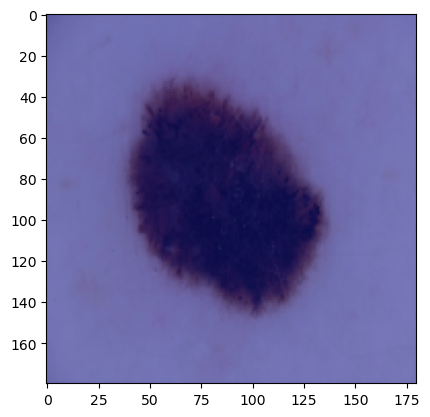

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from lime.lime_image import LimeImageExplainer

# Load the model
model1 = load_model('melanoma_detection_model_final.keras')  # Replace with your model path

# Preprocess the image
Test_image = load_img("/Users/abi/Desktop/MAJOR PROJECT/dataset/test/mel/ISIC_0000013.jpg", target_size=(180, 180))  # Replace with the actual image path
img_array = img_to_array(Test_image) / 255.0  # Rescale the image to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 180, 180, 3)

# Define prediction function for LIME
def predict_fn(images):
    return model1.predict(images)

# Initialize LIME image explainer
explainer = LimeImageExplainer()

# Generate explanation for the test image
explanation = explainer.explain_instance(
    img_array[0],  # Use the first image in the batch
    predict_fn,    # The prediction function
    top_labels=5,  # Top 5 predicted classes
    hide_color=0,  # Hide color of the explanation
    num_samples=1000  # Number of perturbed samples
)

# Get the explanation for the top predicted class
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # Get explanation for the top predicted class
    positive_only=True,         # Highlight the positive contributions only
    num_features=5,             # Limit the number of features (regions) shown
    hide_rest=False             # Don't hide the rest of the image
)

# Visualize the result
plt.imshow(temp)  # Show the original image
plt.imshow(mask, cmap='jet', alpha=0.5)  # Overlay the mask with alpha transparency
plt.show()



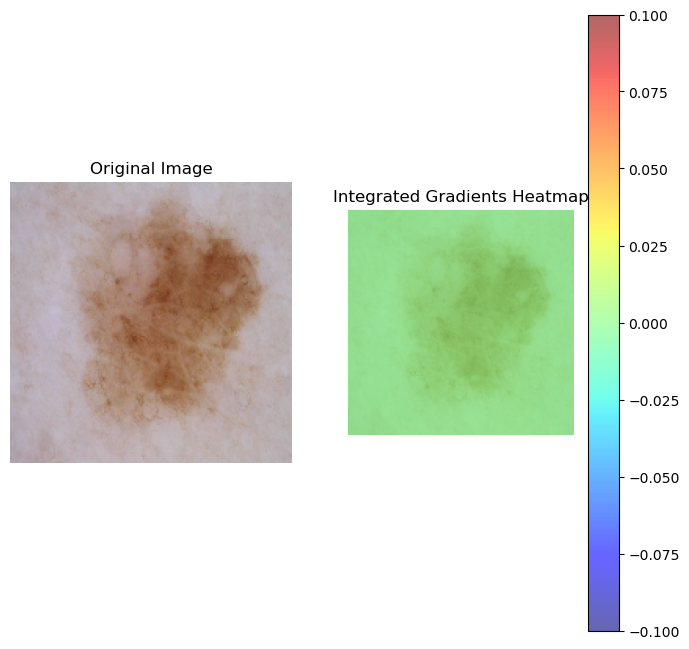

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the model
model = load_model('melanoma_detection_model_final.keras')  # Replace with your model path

# Path to the test image
img_path = "/Users/abi/Desktop/MAJOR PROJECT/dataset/test/mel/ISIC_0000056.jpg"  # Replace with your image path

# Preprocess the image
Test_image = load_img(img_path, target_size=(180, 180))  # Resize image to match model input size (180, 180)
img_array = img_to_array(Test_image) / 255.0  # Rescale the image to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 180, 180, 3)

# Define baseline (black image)
baseline = np.zeros_like(img_array)

# Compute gradients using Integrated Gradients
def compute_integrated_gradients(model, image, baseline, steps=50):
    # Ensure the image and baseline are float32 type
    image = tf.cast(image, tf.float32)
    baseline = tf.cast(baseline, tf.float32)

    # Define the interpolation steps between baseline and the image
    alphas = np.linspace(0, 1, steps)
    gradients = []

    for alpha in alphas:
        # Interpolate between baseline and image
        interpolated_image = baseline + alpha * (image - baseline)
        with tf.GradientTape() as tape:
            tape.watch(interpolated_image)
            prediction = model(interpolated_image)
        grad = tape.gradient(prediction, interpolated_image)
        gradients.append(grad.numpy())

    # Average gradients over all the steps
    avg_gradients = np.mean(np.array(gradients), axis=0)
    integrated_gradients = (image - baseline) * avg_gradients
    return integrated_gradients[0]

# Compute the Integrated Gradients
integrated_gradients = compute_integrated_gradients(model, img_array, baseline)

# Visualize the integrated gradients heatmap
# Sum across the color channels to get a single heatmap
heatmap = np.sum(np.abs(integrated_gradients), axis=-1)


# Clip the heatmap to make sure it's properly visible
heatmap = np.clip(heatmap, 0, 1)

# Create a figure with subplots for both the original image and heatmap overlay
plt.figure(figsize=(8, 8))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(img_array[0])  # Original image
plt.title('Original Image')
plt.axis('off')  # Hide axes

# Display the heatmap on top of the original image
plt.subplot(1, 2, 2)
plt.imshow(img_array[0])  # Original image
plt.imshow(heatmap, cmap='jet', alpha=0.6)  # Overlay heatmap with more transparency (0.6)
plt.title('Integrated Gradients Heatmap')
plt.axis('off')  # Hide axes

# Show the figure
plt.colorbar()
plt.show()

 



In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
model = load_model('melanoma_detection_model_final.keras')

# Define the last convolutional layer name
last_conv_layer_name = 'conv2d_2'  # Update if necessary

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap.numpy()

# Load and preprocess test image
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(180, 180))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img, img_array

# Overlay heatmap on original image
def overlay_heatmap(heatmap, img, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)
    
    heatmap = np.repeat(heatmap, 3, axis=-1)
    heatmap = tf.image.resize(heatmap, (180, 180)).numpy()
    
    superimposed_img = np.uint8(heatmap * alpha + img)
    return superimposed_img

# Test Grad-CAM
img_path = "/Users/abi/Desktop/MAJOR PROJECT/dataset/test/mel/ISIC_0000056.jpg"  # Replace with actual test image path
original_img, img_array = preprocess_image(img_path)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
superimposed_img = overlay_heatmap(heatmap, img_to_array(original_img))

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


AttributeError: The layer sequential has never been called and thus has no defined output.

In [5]:
for layer in model.layers:
    print(layer.name,)


rescaling
conv2d
batch_normalization
max_pooling2d
conv2d_1
batch_normalization_1
max_pooling2d_1
conv2d_2
batch_normalization_2
max_pooling2d_2
dropout
flatten
dense
dropout_1
dense_1
